## Extract ACF by calling a Function

In [32]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
% matplotlib inline
import random
import os, sys


# Set to your datasets folder
path = "E:\AnacondaProject\ACF"
retval = os.getcwd()
print ('****** Please set to your datasets folder, and including  ******')
print ("Original Work Dir:%s" % retval)
os.chdir(path)
retval = os.getcwd()
print("Change to Current Dir:%s" % retval)

****** Please set to your datasets folder, and including  ******
Original Work Dir:E:\AnacondaProject\ACF
Change to Current Dir:E:\AnacondaProject\ACF


In [44]:
def cell_gradient(cell_magnitude, cell_angle,bin_size,angle_unit):
    orientation_centers = [0] * bin_size
    
    for k in range(cell_magnitude.shape[0]):
        for l in range(cell_magnitude.shape[1]):
            #在每个cell中，根据角度信息，向对应的Bin累加mag
            gradient_strength = cell_magnitude[k][l]
            gradient_angle = cell_angle[k][l]
            # 对6取余
            min_angle = int(gradient_angle / angle_unit)% 6
            max_angle = (min_angle + 1) % bin_size
            mod = gradient_angle % angle_unit
            # 根据权重，一部分累计角度所在的Bin,和下一个Bin
            orientation_centers[min_angle] += (gradient_strength * (1 - (mod / angle_unit)))
            orientation_centers[max_angle] += (gradient_strength * (mod / angle_unit))
    return orientation_centers


def ComptChannels(Orig_Img, WinSize = (80,160)):
    '''
    % 获得原图像的相应十幅特征图
    % 输入：原图像，opencv读入BGR, h*w*3 = 160*80*3
    % 输出：特征图像：m*n*10
    % 3*LUV + gradMag + 6*gradHist
    % color:LUV
    % gradMag:Gray
    % gradHist:Gray
    '''
    #不管输入图片的大小，都resize到H160xW80的尺寸 
    
    Crop_img =cv2.resize(Orig_Img,WinSize) # 注意cv2.resize是w*h，反的

    h = Crop_img.shape[0]
    w = Crop_img.shape[1]
    chnl = 10
    
    # Create Feature Channels
    FeatureChannels = np.empty((h, w, chnl))
    
    # 原始RGB图像
    # RGB_Img = cv2.cvtColor(Orig_Img,cv2.COLOR_BGR2RGB)
    # RGB_Img = cv2.normalize(Orig_Img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    # LUV通道
    LUV_Img = cv2.cvtColor(Crop_img,cv2.COLOR_BGR2LUV)
    FeatureChannels[:,:,0:3] = LUV_Img[:,:,:]

    # 梯度特征
    # Gradient Magnitude 梯度幅度特征
    Gray_Img = cv2.cvtColor(Crop_img,cv2.COLOR_BGR2GRAY)
    gradient_values_x = cv2.Sobel(Gray_Img, cv2.CV_64F, 1, 0, ksize=5)
    gradient_values_y = cv2.Sobel(Gray_Img, cv2.CV_64F, 0, 1, ksize=5)
    #计算角度和幅值
    gradient_magnitude, gradient_angle = cv2.cartToPolar(gradient_values_x, gradient_values_y, angleInDegrees=True)

    FeatureChannels[:,:,3] = gradient_magnitude[:,:]

    # HoG特征 
    # Gradient Histograms 梯度直方图特征
    # 划分为4x4的cell，每个cell里求Hist of Gradient 梯度直方图
    height, width = Gray_Img.shape
    cell_size = np.int(4)

    hcell = int(np.ceil(height / cell_size))
    wcell = int(np.ceil(width / cell_size))

    bin_size = np.int(6)
    angle_unit = int(360/bin_size)
    gradient_magnitude = abs(gradient_magnitude)


    # 一个cell由4x4的像素组成
    # 用于存储每个Cell的Gradient Histo
    cell_gradient_vector = np.zeros((hcell, wcell, bin_size))

    #遍历每个20x20的每个cell，统计Gradient Histo
    for i in range(cell_gradient_vector.shape[0]):
        for j in range(cell_gradient_vector.shape[1]):

            # Index获取此cell的Gradient幅值和角度
            cell_magnitude = gradient_magnitude[i * cell_size:(i + 1) * cell_size,j * cell_size:(j + 1) * cell_size]
            cell_angle = gradient_angle[i * cell_size:(i + 1) * cell_size,j * cell_size:(j + 1) * cell_size]
            #print(cell_angle.max())

            # 计算此Cell的Gradient Histo
            cell_gradient_vector[i][j] = cell_gradient(cell_magnitude, cell_angle, bin_size,angle_unit)

            # 分配6个Bin至Feature Channel的4-9的6个通道
            for n in range (bin_size):
                cell_hist_copy = np.ones((cell_size,cell_size)) * cell_gradient_vector[i,j,n]
                #print(cell_hist_copy)
                FeatureChannels[i * cell_size:(i + 1) * cell_size,j * cell_size:(j + 1) * cell_size,n+4] = cell_hist_copy

    NormFeatureChannels = np.empty(FeatureChannels.shape)
    cv2.normalize(FeatureChannels,  NormFeatureChannels, 0, 1, cv2.NORM_MINMAX)
    
    SubChannels = cv2.resize(NormFeatureChannels,(20,40),interpolation=cv2.INTER_CUBIC)
    AcfVec = SubChannels.reshape(-1)
    return AcfVec

(300, 150, 3)
(160, 80, 3)


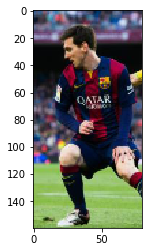

In [48]:
img = cv2.imread('messi5.jpg')
Orig_Img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Crop_img = Orig_Img[:,150:300,:]
print(Crop_img.shape)
inputsize = (80,160)
Crop_img =cv2.resize(Crop_img,inputsize)
print(Crop_img.shape)
plt.imshow(Crop_img)

In [49]:
NormFeatureChannels = ComptChannels(Orig_Img)

print(NormFeatureChannels.shape)
#print(NormFeatureChannels[4:10,4:10,6])

(8000,)
